# Problem Statement

**The global e-commerce industry generates vast amounts of transaction data daily, offering valuable insights into customer purchasing behaviors. Analyzing this data is essential for identifying meaningful customer segments and recommending relevant products to enhance customer experience and drive business growth.**

**This project aims to examine transaction data from an online retail business to uncover patterns in customer purchase behavior, segment customers based on Recency, Frequency, and Monetary (RFM) analysis, and develop a product recommendation system using collaborative filtering techniques.**


In [1]:
import pandas as pd

In [2]:
df =pd.read_csv('/content/drive/MyDrive/online_retail.csv')

# EDA

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
df.shape

(541909, 8)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [6]:
df.duplicated().value_counts()

,count
False,536641
True,5268


In [7]:
# removing duplicate rows

df.drop_duplicates(inplace=True)

In [8]:
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135037
Country,0


In [9]:
#dropping the rows with nulls

df.dropna(subset=['CustomerID'], inplace =True)

In [10]:
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0


In [11]:
# check for negative Quantity and UnitPrice

print(df[df['UnitPrice']<0].head())

print(df[df['Quantity']<0].head())

Empty DataFrame
Columns: [InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country]
Index: []
    InvoiceNo StockCode                       Description  Quantity  \
141   C536379         D                          Discount        -1   
154   C536383    35004C   SET OF 3 COLOURED  FLYING DUCKS        -1   
235   C536391     22556    PLASTERS IN TIN CIRCUS PARADE        -12   
236   C536391     21984  PACK OF 12 PINK PAISLEY TISSUES        -24   
237   C536391     21983  PACK OF 12 BLUE PAISLEY TISSUES        -24   

             InvoiceDate  UnitPrice  CustomerID         Country  
141  2022-12-01 09:41:00      27.50     14527.0  United Kingdom  
154  2022-12-01 09:49:00       4.65     15311.0  United Kingdom  
235  2022-12-01 10:24:00       1.65     17548.0  United Kingdom  
236  2022-12-01 10:24:00       0.29     17548.0  United Kingdom  
237  2022-12-01 10:24:00       0.29     17548.0  United Kingdom  


In [12]:
# dropping rows with negative quantity

df.drop(df[df['UnitPrice']<0].index, inplace=True)

In [13]:
df.shape

(401604, 8)

In [14]:
# Remove cancelled orders

df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]


In [15]:
df.shape

(392732, 8)

# Visual Analysis

In [39]:
# transaction volume for top 10 countries

import plotly.express as px

country_tx = df.groupby('Country')['InvoiceNo'].nunique().reset_index().sort_values('InvoiceNo', ascending=False).head(10)

fig = px.bar(country_tx,
             x='InvoiceNo',
             y='Country',
             orientation='h',
             color='InvoiceNo',
             color_continuous_scale='viridis',
             title='Transaction Volume by Country')
fig.update_layout(yaxis=dict(autorange='reversed'))
fig.show()


United Kingdom dominates the transaction volume by a significant margin, far exceeding all other countries.

Countries like Germany, France, and EIRE follow distantly, indicating a smaller but notable customer base.

Other countries show minimal transaction activity, suggesting potential markets for expansion or limited customer engagement

In [42]:
# top selling products

top_products = df.groupby('Description')['Quantity'].sum().reset_index()
top_products = top_products.sort_values('Quantity', ascending=False).head(10)

fig = px.bar(top_products,
             x='Quantity',
             y='Description',
             orientation='h',
             color='Quantity',
             color_continuous_scale='blues',
             title='Top 10 Selling Products')
fig.update_layout(yaxis=dict(autorange='reversed'))
fig.show()



"PAPER CRAFT , LITTLE BIRDIE" and "MEDIUM CERAMIC TOP STORAGE JAR" are the top-selling products by a significant margin, each selling around 80,000 units.

The remaining products show a noticeable drop in quantity sold, with "WORLD WAR 2 GLIDERS ASSTD DESIGNS" and "JUMBO BAG RED RETROSPOT" leading the mid-tier sales group.

The distribution indicates a few dominant products drive a large share of total sales, suggesting strong product preference concentration.

In [43]:
# purchase trend over time

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
daily_tx = df.set_index('InvoiceDate').resample('D')['InvoiceNo'].nunique().reset_index()

fig = px.line(daily_tx,
              x='InvoiceDate',
              y='InvoiceNo',
              title='Daily Purchase Trends',
              labels={'InvoiceDate': 'Date', 'InvoiceNo': 'Transactions'})
fig.show()


1. Upward Trend in Transactions
There's a clear increase in daily transactions over time, especially noticeable from mid-2023 onward.

This suggests growing user engagement or seasonal demand rise.

2. Repetitive Dips in Data
The plot shows regular sharp drops to near-zero values—likely due to non-operating days (e.g., weekends or holidays) .

This repetitive pattern indicates potential cyclical behavior or data quality gaps.

3. Higher Volatility Early On
Early 2023 shows erratic spikes and drops, while later months exhibit more consistent and higher transaction volumes.

This could imply a period of user onboarding or testing phase initially, getting into regular use later.



# Feature Engineering

In [16]:
# converting InvoiceDate column to datetime

df['InvoiceDate']= pd.to_datetime(df['InvoiceDate'])

In [18]:
df['TotalPrice'] = df['Quantity']* df['UnitPrice']

In [19]:
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

In [20]:
# Recency, frequency and monetary calculation

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,   # Recency
    'InvoiceNo': 'nunique',                                     # Frequency
    'TotalPrice': 'sum'                                         # Monetary
}).reset_index()

In [34]:
# Rename columns

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
rfm.drop('CustomerID', axis=1)

,Recency,Frequency,Monetary
0,326,1,77183.60
1,2,7,4310.00
2,75,4,1797.24
3,19,1,1757.55
4,310,1,334.40
...,...,...,...
4334,278,1,180.60
4335,181,1,80.82
4336,8,2,178.05
4337,4,16,2045.53


# Customer Segmentation

Customer segmentation is the process of dividing a company’s customer base into distinct groups based on shared characteristics such as behavior, demographics, spending patterns, or engagement levels. One popular method is RFM segmentation, which groups customers based on:

1. Recency – How recently a customer made a purchase

2. Frequency – How often they purchase

3. Monetary – How much money they spend


**Why is Customer Segmentation Needed?**

**1. Personalized Marketing**

Tailor messages and offers to each group, improving customer experience and response rates.

**2. Resource Optimization**

Focus efforts and budget on high-value segments like Champions or Loyal customers, rather than treating all customers the same.

**3. Customer Retention**

Identify and re-engage at-risk segments like Hibernating or Lost customers through targeted strategies.

**4. Better Product & Service Development**

Understand what each segment values most, helping design more relevant offerings to them.

**5. Improved Business Strategy**

Segments provide clear insights for sales forecasting, campaign planning, and business growth decisions.



In [ ]:
# scale data

import pickle
from sklearn.preprocessing import StandardScaler

X = rfm[['Recency', 'Frequency', 'Monetary']]

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

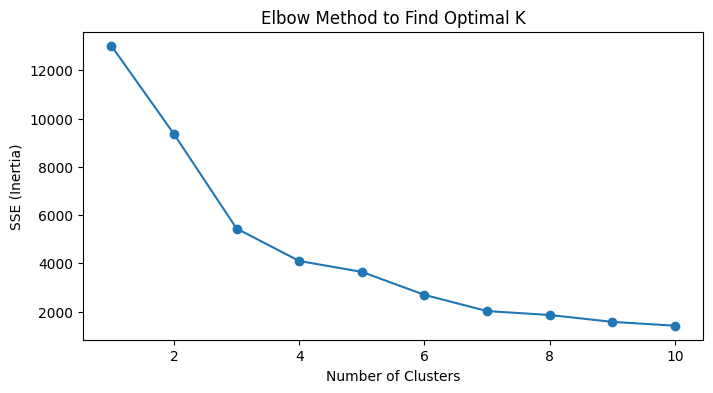

In [159]:
# elbow method to find optimal cluster

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE (Inertia)')
plt.title('Elbow Method to Find Optimal K')
plt.show()


The optimal number of clusters is 4.

# K-Means Algorithm

In [166]:
# k-means for 4 clusters

kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)


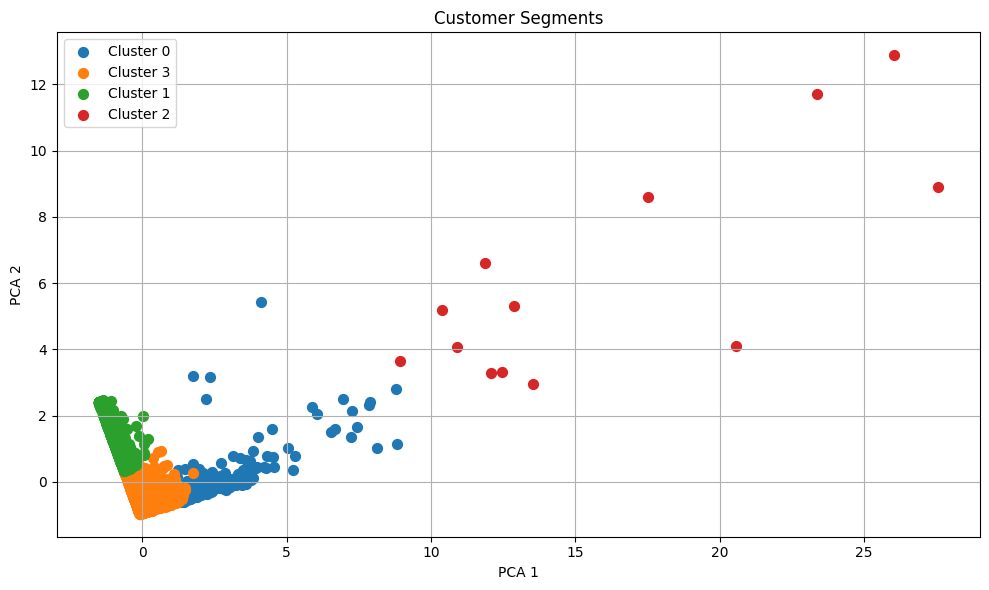

In [168]:
# visualizing clusters using PCA

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce to 2 dimensions for visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(rfm_scaled)

# Add PCA components to the DataFrame
rfm['PCA1'] = pca_components[:, 0]
rfm['PCA2'] = pca_components[:, 1]

# Plot
plt.figure(figsize=(10, 6))
for cluster in rfm['Cluster'].unique():
    subset = rfm[rfm['Cluster'] == cluster]
    plt.scatter(subset['PCA1'], subset['PCA2'], label=f'Cluster {cluster}', s=50)

plt.title('Customer Segments')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [169]:
# Average RFM values per cluster

rfm_summary = rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean().round(1)
rfm_summary['Count'] = rfm['Cluster'].value_counts().sort_index()
rfm_summary


,Recency,Frequency,Monetary,Count
Cluster,,,,
0,15.7,22.0,12435.1,211
1,248.6,1.6,476.3,1062
2,7.4,82.7,127188.0,13
3,43.9,3.7,1344.3,3053


From the above summary, we can conclude:


1. **Cluster 2 (Big Spenders):**

With the lowest recency (7.4 days), extremely high frequency (82.7), and an exceptionally high monetary value (127,188.0), these 13 customers are the most valuable and highly engaged top-tier customers.

2. **Cluster 0 (Loyal Customers):**

These customers have relatively recent activity (15.7 days), strong frequency (22.0), and solid monetary value (12,435.1). This group of 211 customers represents a loyal base that regularly engages and spends well.

3. **Cluster 3 (Occasional / New Customers):**

This largest group of 3,053 customers has moderate recency (43.9 days), low frequency (3.7), and low to moderate spend (1,344.3). They are either occasional shoppers or newly acquired customers who haven’t yet formed strong purchasing habits.

4. **Cluster 1 (Lost / Hibernating Customers):**

These 1,062 customers show high recency (248.6 days), very low frequency (1.6), and low spend (476.3). They are likely inactive or churned. Consider re-engagement or win-back campaigns for this group.


In [129]:
# naming the customers based on their buying pattern

def map_cluster_to_segment(cluster):
    if cluster == 2:
        return "Big Spenders"
    elif cluster == 0:
        return "Loyal"
    elif cluster == 3:
        return "Ocassional"
    elif cluster == 1:
        return "Lost"

# Create the new column
rfm['Customer_Segment'] = rfm['Cluster'].map(map_cluster_to_segment)


In [130]:
rfm.head()

,Recency,Frequency,Monetary,Cluster,PCA1,PCA2,Customer_Segment
0,326,1,77183.60,0,4.111043,5.435509,Loyal
1,2,7,4310.00,3,0.742495,-0.671043,Ocassional
2,75,4,1797.24,3,0.025141,-0.174529,Ocassional
3,19,1,1757.55,3,-0.027574,-0.734635,Ocassional
4,310,1,334.40,1,-1.234521,1.835732,Lost


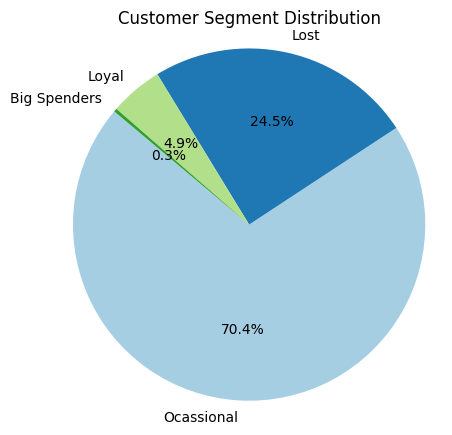

In [131]:
import matplotlib.pyplot as plt

# number of customers in each segment
segment_counts = rfm['Customer_Segment'].value_counts()

# Plot  pie chart
plt.figure(figsize=(5,5))
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title("Customer Segment Distribution")
plt.axis('equal')
plt.show()


1. **Occasional Customers** make up the largest segment (≈70.4%), indicating a broad customer base that buys infrequently or has just started engaging. This group has growth potential—consider nurturing them with personalized recommendations or loyalty nudges to increase frequency and value.

2. **Lost or Hibernating Customers** account for about 24.5%. These users haven’t engaged recently and contribute little revenue. There’s significant room for reactivation campaigns like win-back emails, offers, or surveys to understand their drop-off.

3. **Loyal Customers** represent around 4.9% of the base. Though small, they are consistent spenders and frequent buyers—prime candidates for retention, feedback collection, and referral incentives.

4. **Big Spenders (VIP Customers)** are a tiny segment (≈0.3%) but likely contribute a disproportionately high share of revenue. These top-tier users should be treated with exclusive perks, early access, or high-touch engagement to retain their loyalty.


- The customer base is **heavily skewed toward occasional users**, which offers scale but also **risk of low retention**.

- While **VIPs are few**, they are worth significant strategic focus.

- Increasing the share of **loyal customers** from your **occasional pool** should be a key growth strategy.

- Re-engaging the **hibernating users** can give a direct lift to repeat purchase rates.



In [ ]:
# Saving the model for later use

with open("scaler_3.pkl", "wb") as f:
    pickle.dump(scaler, f)

with open("kmeans_model_new.pkl", "wb") as f:
    pickle.dump(kmeans, f)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Save to Drive
!cp kmeans_model_new.pkl /content/drive/MyDrive/

!cp scaler_3.pkl /content/drive/MyDrive/

# Recommendation System

A Recommendation System in e-commerce is a tool that suggests products or services to users based on their browsing history, past purchases, ratings, or behavior. It’s like a personalized system that helps users discover items they are likely to buy.

Common types of recommendation systems include:

Collaborative Filtering: Recommends items based on what similar users liked

Content-Based Filtering: Suggests items similar to what the user liked before

Hybrid Models: Combine both methods for better recommendations


**Why Recommendation System is Needed in E-commerce?**

**1. Personalized Shopping Experience**

It makes users feel understood by showing products that match their interests.

**2.Increased Sales and Revenue**

Recommending relevant items boosts upselling and cross-selling opportunities.

**3. Better Customer Engagement**

Keeps users browsing longer and coming back for more.

**4. Efficient Product Discovery**

Helps users navigate large catalogs quickly and find what they need.

**5. Data-Driven Decisions**

Uses customer behavior data to fine-tune marketing and product strategies.






In [ ]:
df

In [35]:
# creating a pivot table

user_item_matrix = df.pivot_table(index="CustomerID", columns="Description", values="TotalPrice", aggfunc='sum')
user_item_matrix.fillna(0, inplace=True)


In [90]:
user_item_matrix

Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,I LOVE LONDON MINI RUCKSACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12347.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12348.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12349.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12350.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18280.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18281.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,16.95,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18282.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
from sklearn.metrics.pairwise import cosine_similarity


# Cosine similarity
item_sim = cosine_similarity(user_item.T)
item_sim_df = pd.DataFrame(item_sim, index=user_item.columns, columns=user_item.columns)

# For visualization: take top 20 products only
top_20_items = item_sim_df.iloc[:20, :20]

fig = px.imshow(top_20_items,
                labels=dict(x="Product", y="Product", color="Similarity"),
                title="Product Recommendation Heatmap (Top 20 Products)",
                x=top_20_items.columns,
                y=top_20_items.index,
                color_continuous_scale='magma')
fig.update_layout(width=800, height=800)
fig.show()


"DOLLY GIRL BEAKER", "I LOVE LONDON MINI BACKPACK", and "I LOVE LONDON MINI RUCKSACK" show high mutual similarity, suggesting they are often bought together.

"10 COLOUR SPACEBOY PEN" and "SPACEBOY BABY GIFT SET" also display strong similarity, likely appealing to the same customer segment.

Multiple "I LOVE LONDON" items form a tight similarity cluster, indicating customers buying one London-themed product are likely to buy others.

Items like "12 COLOURED PARTY BALLOONS", "12 HANGING EGGS HAND PAINTED", and "12 EGG HOUSE PAINTED WOOD" share moderate similarity, pointing to a party/gift decor category.

Items such as "TRELLIS COAT RACK" or "NINE DRAWER OFFICE TIDY" have low similarity with others, indicating they are purchased more independently.


**User-user collaborative filtering**

User-user collaborative filtering method recommends products to a user by finding similar users.

It looks at how users have rated or interacted with items, and suggests items liked by users who behave like the target user.

In [37]:
# user-user collaborative filtering

from sklearn.metrics.pairwise import cosine_similarity

# Compute user similarity
user_similarity = cosine_similarity(user_item_matrix)
user_sim_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)



In [38]:
   def predict_user_user(product_name, top_n=5):
    if product_name not in user_item_matrix.columns:
        return None

    users_who_bought = user_item_matrix[user_item_matrix[product_name] > 0].index


    similar_users = user_sim_df.loc[users_who_bought].mean(axis=0).sort_values(ascending=False)

    similar_users = similar_users.drop(users_who_bought, errors='ignore')
    top_similar_users = similar_users.head(10).index

    recommended_products = user_item_matrix.loc[top_similar_users].mean(axis=0)


    recommended_products = recommended_products.drop(product_name, errors='ignore')

    return recommended_products.sort_values(ascending=False).head(top_n).reset_index().rename(
        columns={0: "Score", "index": "Product Description"})


**Item-Item Collaborative filtering**

In Item-item collaborative filtering, recommendations are based on the similarity between items.

It checks what other items are often liked together and suggests those.



In [39]:
# Compute item similarity

item_similarity = cosine_similarity(user_item_matrix.T)
item_sim_df = pd.DataFrame(item_similarity, index=user_item_matrix.columns, columns=user_item_matrix.columns)


In [40]:
def predict_item_item(product_name, top_n=5):
    if product_name not in item_sim_df.columns:
        return None

    similar_items = item_sim_df[product_name].sort_values(ascending=False).drop(index=product_name)
    return similar_items.head(top_n).reset_index().rename(
        columns={product_name: "Similarity Score", "index": "Product Description"})

In [87]:
def recommend_top_n(product_name, n=5, method='item'):
    predictions = {}

    if product_name not in user_item_matrix.columns:
        return None

    if method == 'item':
        # Item-Item recommendation
        sim_scores = item_sim_df[product_name].drop(index=product_name)
        top_n = sim_scores.sort_values(ascending=False).head(n)
        return pd.DataFrame(top_n).reset_index().rename(
            columns={product_name: "Predicted Interest Score", "index": "Product Description"}
        )

    elif method == 'user':
        # User-User recommendation
        users_who_bought = user_item_matrix[user_item_matrix[product_name] > 0].index
        if len(users_who_bought) == 0:
            return None

        similar_users = user_sim_df.loc[users_who_bought].mean(axis=0)
        similar_users = similar_users.drop(users_who_bought, errors='ignore')
        top_similar_users = similar_users.sort_values(ascending=False).head(10).index

        # Aggregate item scores from similar users
        avg_ratings = user_item_matrix.loc[top_similar_users].mean(axis=0)

        avg_ratings = avg_ratings.drop(index=product_name, errors='ignore')

        top_n = avg_ratings.sort_values(ascending=False).head(n)
        return pd.DataFrame(top_n).reset_index().rename(
            columns={0: "Predicted Interest Score", "index": "Product Description"}
        )
    else:
        raise ValueError("Method must be 'item' or 'user'")



In [88]:
# check for a user similarity

recommend_top_n("WHITE HANGING HEART T-LIGHT HOLDER", n=5, method='user')

,Description,Predicted Interest Score
0,SPOTTY BUNTING,160.875
1,ASSORTED COLOUR BIRD ORNAMENT,128.440
2,PARTY BUNTING,116.370
3,REGENCY CAKESTAND 3 TIER,113.145
4,JUMBO BAG RED RETROSPOT,89.973


In [89]:
# check for an item similarity

recommend_top_n("WHITE HANGING HEART T-LIGHT HOLDER", n=5, method='item')


,Description,Predicted Interest Score
0,GIN + TONIC DIET METAL SIGN,0.763539
1,RED HANGING HEART T-LIGHT HOLDER,0.741223
2,WASHROOM METAL SIGN,0.728206
3,LAUNDRY 15C METAL SIGN,0.727322
4,GREEN VINTAGE SPOT BEAKER,0.719897


In [91]:
import pickle

# Save user-item matrix
with open('user_item_matrix.pkl', 'wb') as f:
    pickle.dump(user_item_matrix, f)

# Save user similarity matrix
with open('user_sim_df.pkl', 'wb') as f:
    pickle.dump(user_sim_df, f)

# Save item similarity matrix
with open('item_sim_df.pkl', 'wb') as f:
    pickle.dump(item_sim_df, f)

In [92]:
from google.colab import drive
drive.mount('/content/drive')

# save files to Drive
!cp user_item_matrix.pkl /content/drive/MyDrive/
!cp user_sim_df.pkl /content/drive/MyDrive/
!cp item_sim_df.pkl /content/drive/MyDrive/


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
